---
# Aggregate .sro mass balance by oil type & plot
Create graphic for oil spill fate by "location category" 
i.e. water column, water surface, beach, and air (evaporation)
---

#### Steps for generating this graphic

1. Oil type is identified by the Lagrangian output file name in 
[create_SOILED_sro_runlist.ipynb](https://github.com/MIDOSS/analysis-rachael/blob/main/notebooks/monte_carlo/create_SOILED_sro_runlist.ipynb). See function `get_SOILED_sro_filenames_byOil`
2. Either In[5] or In[7] is used to open existing files or create new files in which mass information is gathered from runs and organized by oil type.  It's not a very clean method, but it's what I have right now. The script for sorting oil mass is called aggregate_sro_mass_byoil in [aggregate_sro_mass.py](https://github.com/MIDOSS/analysis-rachael/blob/main/scripts/monte_carlo/aggregate_sro_mass.py), line 157.  An oil dictionary is used to group the mass balance output values in the *.sro files (see line 209 of `aggregate_sro_mass.py`). Some of the variables are then grouped to create the surface, water column, beach, and air locations seen there.  

In [1]:
import sys
sys.path.insert(1, '../../scripts/')
sys.path.insert(1, '../../scripts/monte_carlo')
from aggregate_sro_mass import aggregate_sro_mass_byoil
from aggregate_sro_mass import aggregate_sro_mass_all
sys.path.insert(1, '../presentations/MEOPAR2022/')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import datetime
from midoss_utils import *
import yaml
import time
from glob import glob
import os
from datetime import datetime

from os.path import exists
# compress helps to extract values from list based on the value in a column
# e.g. dissolution < 0.0
from itertools import compress
# graphics style
plt.style.use(r"../presentations/MEOPAR2022/meopar2022_matplotlibrc.template")

# predefined naming conventions
import MEOPAR2022_setup as oil


MIDOSScolors={
    'ANS': 'darkslategrey',
    'Bunker-C':'teal',
    'Dilbit':'slategrey',
    'Diesel':'darkgoldenrod',
}

In [2]:
color_dict = {"MEvaporated": "darkolivegreen",
              "MDispersed": "darkblue", 
              "MDissolved": "royalblue", 
              "MBio": "skyblue",
              "MFloating": "saddlebrown", 
             "MBeached": "chocolate", 
             "MInitial": "grey",
             "MTotal":"magenta"}
oil_dict = {"akns":"ANS",
            "all":"all",
           "bunker":"Bunker-C",
           "diesel":"Diesel",
           "dilbit":"Dilbit",
           "gas":"Diesel",
           "jet":"Diesel",
           "other":"Bunker-C"}
cols_plot = ["MEvaporated", "MDispersed",  "MDissolved", "MBio", "MFloating", "MBeached", "MInitial","MTotal"]
oil_types = ["Bunker-C", "Diesel", "Dilbit", "ANS"]
# Select True to re-run cataloguing code and False to open "input_file" instead
catalogue_flag = False
process_sro_flag = True

In [3]:
# directories
output_dir =Path('/scratch/rmueller/MIDOSS/Results/try3')
graphics_dir = Path('/home/rmueller/projects/def-allen/rmueller/MIDOSS/graphics/')

In [4]:
def get_SOILED_sro_filenames_byOil(
    results_dir='/scratch/dlatorne/MIDOSS/runs/monte-carlo',
    output_dir ='/scratch/rmueller/MIDOSS/Results/try3',
    runset_tag="*_near-BP_try3*"):
    """Get lists of filepaths and filenames for netcdf files of model output, 
    grouped by oil types. NOTE: jet and gas are run as diesel; other is run 
    as bunker.  
    
    :param str results_dir: File path for root directory of run sets. 
    On Graham, the filepath is `/scratch/dlatorne/MIDOSS/runs/monte-carlo`
    
    :param str output_dir: File path for storing MOHID_results_locations_{date}.yaml,
    which contains file paths for completed runs, sorted by oil type.  
    
    :return: Dataframe of file paths and names, sorted by oil types, namely: 
    akns, bunker, dilbit, jet, diesel, gas and other.  Note: jet and gas are 
    run as diesel; other is run as bunker.  
    :rtype: :py:class:`pandas.DataFrame`
    
    :return: output .yaml file name
    """
    results_dir='/scratch/dlatorne/MIDOSS/runs/monte-carlo'
    # specify directory search tags
    runset_tag = "*_near-BP_try3*"

    # get list of runsets
    runsets = sorted(glob(os.path.join(results_dir,runset_tag)))
    # get list of runs within each runset
    runs = []
    sro_files = []
    netcdf_files = []
    missing_netcdf = []
    for runset in runsets:
        runs.extend(sorted(
            glob(os.path.join(runset,"results",runset_tag)))[:])
    for run in runs:
        try:
            exists(glob(os.path.join(run,'*.nc'))[0])
        except:
            missing_netcdf.append(os.path.join(run,'*.nc'))
        else:    
            sro_files.append(sorted(
                glob(os.path.join(run,'*.sro')))[0])
            netcdf_files.append(sorted(
                glob(os.path.join(run,'*.nc')))[0])
    file_boolean = {}
    files = {}
    files['all'] = []
    oil_types = [
        "akns", "bunker", "dilbit", "jet", "diesel", "gas", "other"
    ]
    for oil in oil_types:
        # Use lagrangian filename to ID and allocate .sro oil type
        file_boolean[oil] = [oil in file for file in netcdf_files]
        files[oil]=[file for i,file in enumerate(sro_files) \
            if file_boolean[oil][i]]
        files['all'].extend(files[oil])
    files['all'].sort()
    # write filenames to .yaml with timestamp in filename
    now = datetime.now()
    dt_string = now.strftime("%d%m%Y_%H:%M:%S")
    out_f = output_dir+f'/MOHID_massbalance_byOil_try3_{dt_string}.yaml'
    try:
        with open(out_f, 'w') as output_yaml:
            documents = yaml.safe_dump(files, output_yaml)
    except:
        print("Save to yaml didn't work")
    return files, out_f

In [5]:
%%time
if process_sro_flag:
    print('Creating dictionary of netcdf filenames sorted by oil type.')
    print('This will take a few minutes.')
    files, out_f = get_SOILED_sro_filenames_byOil()
else:
    out_f=output_dir/"MOHID_massbalance_byOil_try3_15062022_01:26:17.yaml"

Creating dictionary of netcdf filenames sorted by oil type.
This will take a few minutes.
CPU times: user 5.59 s, sys: 4.3 s, total: 9.88 s
Wall time: 1min 29s


In [6]:
from aggregate_sro_mass import aggregate_sro_mass_byoil
sro = aggregate_sro_mass_byoil(out_f, output_dir)

akns
bunker
diesel
dilbit
gas
jet
other


In [7]:
# %%time
# results_dir='/scratch/dlatorne/MIDOSS/runs/monte-carlo'
# # specify directory search tags
# runset_tag = "*_near-BP_try3*"

# # get list of runsets
# runsets = sorted(glob(os.path.join(results_dir,runset_tag)))
# # get list of runs within each runset
# runs = []
# sro_files = []
# netcdf_files = []
# missing_netcdf = []
# for runset in runsets:
#     runs.extend(sorted(
#         glob(os.path.join(runset,"results",runset_tag)))[:])
# for run in runs:
#     # There are 9833 netcdf and 9841 sro files.  I only choose .sro files
#     # where netcdf exist
#     try:
#         exists(glob(os.path.join(run,'*.nc'))[0])
#     except:
#         missing_netcdf.append(os.path.join(run,'*.nc'))
#     else:    
#         sro_files.append(sorted(
#             glob(os.path.join(run,'*.sro')))[0])
#         netcdf_files.append(sorted(
#             glob(os.path.join(run,'*.nc')))[0])
# file_boolean = {}
# files = {}
# files['all'] = []
# oil_types = [
#     "akns", "bunker", "dilbit", "jet", "diesel", "gas", "other"
# ]
# for oil in oil_types:
#     # Use lagrangian filename to ID and allocate .sro oil type
#     file_boolean[oil] = [oil in file for file in netcdf_files]
#     files[oil]=[file for i,file in enumerate(sro_files) \
#         if file_boolean[oil][i]]
#     files['all'].extend(files[oil])
# files['all'].sort()
# # write filenames to .yaml with timestamp in filename
# now = datetime.now()
# dt_string = now.strftime("%d%m%Y_%H:%M:%S")
# out_f = output_dir/f'MOHID_massbalance_byOil_try3_{dt_string}.yaml'
# with open(out_f, 'w') as output_yaml:
#     documents = yaml.safe_dump(files, output_yaml)

### sort filenames by oil type.  

### Function for aggregating the mass values in MOHID model output

In [8]:
# out_f=output_dir/"MOHID_massbalance_byOil_try3_15062022_01:26:17.yaml"
# sro = aggregate_sro_mass_byoil(out_f, output_dir)

In [9]:
with open(out_f) as file:
    sro_files = yaml.safe_load(file)

In [10]:
[*sro_files]

['akns', 'all', 'bunker', 'diesel', 'dilbit', 'gas', 'jet', 'other']

In [11]:
total_files=0
for oil in [*sro_files]:
    print(len(sro_files[oil]))
    if oil !='all':
        total_files += len(sro_files[oil])
print('TOTAL: ', total_files)

64
9833
3347
6250
1
76
26
69
TOTAL:  9833


### calculate geometric mean of mass values by month
- total (MEvaporated + MDispersed + MDissolved + MBio + MSurface + MBeached)
- surface (MassOil)
- beached (MBeached)
- water column (MDispersed, MDissolved, MBio)

In [12]:

df={}
df['ANS'] = pandas.DataFrame(sro['ANS'])
df['Bunker-C'] = pandas.DataFrame(sro['Bunker-C'])
df['Diesel'] = pandas.DataFrame(sro['Diesel'])
df['Dilbit'] = pandas.DataFrame(sro['Dilbit'])

# specify key words
oil_types = ['ANS', 'Bunker-C', 'Diesel', 'Dilbit']
#oil_types = ['ANS', 'Bunker-C', 'Diesel']
locations = ['water','sfc','beach','air']
# initialize dictionaries
water = {}
sfc = {}
beach = {}
air = {}
time={}
initial={}
final={}
tmp={}
mass_max = {}
combined_mass = {}
total_mass = {}
# create dictionary of mean values (update code later to use this method for geometric mean values!)
mean = {}
for location in locations:
    mean[location] = {}
    final[location]={}
    for oil in oil_types:
        final[location][oil]=[]
# cataloge information by oil type
for oil in oil_types:
    print(oil)
    # number of spills with positive dissolution (note: for Bunker but applied to all)
    Nspills = len(df[oil]['MDissolved'].loc[df[oil]['MDissolved']>0])
    water_col = (df[oil]['MDispersed'].loc[df[oil]['MDissolved']>0] + 
        df[oil]['MDissolved'].loc[df[oil]['MDissolved']>0] + 
        df[oil]['MBio'].loc[df[oil]['MDissolved']>0])
    # remove values associated with bogus dissolution/evaporation/surface
    surface = df[oil]['MassOil'].loc[df[oil]['MDissolved']>0]
    beached = df[oil]['MBeached'].loc[df[oil]['MDissolved']>0]
    evaporated = df[oil]['MEvaporated'].loc[df[oil]['MDissolved']>0]
    # get vectors of spill duration 
    time[oil]=df[oil]['days_since_spill'].loc[df[oil]['MDissolved']>0]
    # calculate geometric means
    water[oil]=numpy.exp(numpy.log(water_col.loc[water_col>0]).sum()/ Nspills)
    sfc[oil]=numpy.exp(numpy.log(surface.loc[surface>0]).sum()/ Nspills)
    beach[oil]=numpy.exp(numpy.log(beached.loc[beached>0]).sum()/ Nspills)
    air[oil]=numpy.exp(numpy.log(evaporated.loc[evaporated>0]).sum()/ Nspills)
    # Add up total, initial oil mass
    initial[oil]=df[oil]['MInitial'].loc[df[oil]['MDissolved']>0]
    # Save array of final, total oil mass for all runs
    final['water'][oil]=water_col
    final['sfc'][oil]=surface
    final['beach'][oil]=beached
    final['air'][oil]=evaporated
    # calculate means
    mean['water'][oil] = water_col.sum()/ Nspills
    mean['sfc'][oil] = surface.sum()/ Nspills
    mean['beach'][oil] = beached.sum()/ Nspills
    mean['air'][oil] = evaporated.sum()/Nspills
    # all but evaporation
    combined_mass[oil] = water_col.sum() + surface.sum() + beached.sum()
    total_mass[oil] = combined_mass[oil] + evaporated.sum()

ANS
Bunker-C
Diesel
Dilbit


### Create dataframes of values for:
- median
- mean
- stdev
- min
- max
- quantiles (0.25, 0.50, 0.75)

In [13]:
# specify key words
oil_types = ['ANS', 'Bunker-C', 'Diesel', 'Dilbit']
#oil_types = ['ANS', 'Bunker-C', 'Diesel']
locations = ['water','sfc','beach','air']
# initialize dictionaries
water = {}
sfc = {}
beach = {}
air = {}
time={}
initial={}
final={}
tmp={}
mass_max = {}
combined_mass = {}
total_mass = {}
# create dictionary of mean values (update code later to use this method for geometric mean values!)
mean = {}
for location in locations:
    mean[location] = {}
    final[location]={}
    for oil in oil_types:
        final[location][oil]=[]
# cataloge information by oil type
for oil in oil_types:
    print(oil)
    # number of spills with positive dissolution (note: for Bunker but applied to all)
    Nspills = len(df[oil]['MDissolved'].loc[df[oil]['MDissolved']>0])
    water_col = (df[oil]['MDispersed'].loc[df[oil]['MDissolved']>0] + 
        df[oil]['MDissolved'].loc[df[oil]['MDissolved']>0] + 
        df[oil]['MBio'].loc[df[oil]['MDissolved']>0])
    # remove values associated with bogus dissolution/evaporation/surface
    surface = df[oil]['MassOil'].loc[df[oil]['MDissolved']>0]
    beached = df[oil]['MBeached'].loc[df[oil]['MDissolved']>0]
    evaporated = df[oil]['MEvaporated'].loc[df[oil]['MDissolved']>0]
    # get vectors of spill duration 
    time[oil]=df[oil]['days_since_spill'].loc[df[oil]['MDissolved']>0]
    # calculate geometric means
    water[oil]=numpy.exp(numpy.log(water_col.loc[water_col>0]).sum()/ Nspills)
    sfc[oil]=numpy.exp(numpy.log(surface.loc[surface>0]).sum()/ Nspills)
    beach[oil]=numpy.exp(numpy.log(beached.loc[beached>0]).sum()/ Nspills)
    air[oil]=numpy.exp(numpy.log(evaporated.loc[evaporated>0]).sum()/ Nspills)
    # Add up total, initial oil mass
    initial[oil]=df[oil]['MInitial'].loc[df[oil]['MDissolved']>0]
    # Save array of final, total oil mass for all runs
    final['water'][oil]=water_col
    final['sfc'][oil]=surface
    final['beach'][oil]=beached
    final['air'][oil]=evaporated
    # calculate means
    mean['water'][oil] = water_col.sum()/ Nspills
    mean['sfc'][oil] = surface.sum()/ Nspills
    mean['beach'][oil] = beached.sum()/ Nspills
    mean['air'][oil] = evaporated.sum()/Nspills
    # all but evaporation
    combined_mass[oil] = water_col.sum() + surface.sum() + beached.sum()
    total_mass[oil] = combined_mass[oil] + evaporated.sum()

ANS
Bunker-C
Diesel
Dilbit


### Create dataframe for graphing fate by month

In [14]:
locations = ['water','sfc','beach','air']
opperations = ['median','mean','std','min','max']
job='median'
getattr(numpy, job)([0, 2, 3])
#numpy.median([0, 2, 3])
persist = {}

# Calculate Quantiles
persist['Q1']={}
persist['Q2']={}
persist['Q3']={}
for oil in ['ANS','Bunker-C','Diesel']:
    persist['Q1'][oil]={}
    persist['Q2'][oil]={}
    persist['Q3'][oil]={}
    for loc in locations:
        #Quantile 0.25 (in percent form)
        persist['Q1'][oil][loc]=100*numpy.quantile(
            final[loc][oil]/(initial[oil]), .25)
        #Quantile 0.5 (median, in percent form)
        persist['Q2'][oil][loc]=100*numpy.quantile(
            final[loc][oil]/(initial[oil]), .50)
        #Quantile 0.75 (in percent form)
        persist['Q3'][oil][loc]=100*numpy.quantile(
            final[loc][oil]/(initial[oil]), .75)

# Calculate other stats across persistence fractions
print('Calculating the following stats across persistence fraction')
for opp in opperations:
    print("|_", opp)
    persist[opp]={}  
    for oil in ['ANS','Bunker-C','Diesel']:
        print("    |_", oil)
        persist[opp][oil]={}
        for loc in locations:
            print("        |_", loc)
            # final mass (by category) over initial spill
            persist[opp][oil][loc]=getattr(numpy, opp)(
                100*final[loc][oil]/(initial[oil])
            )
# Add Quantiles to opperations
opperations = ['median','mean','std','min','max','Q1','Q2','Q3']
persist_df={}
print('-------------------')
print('BUILDING DATAFRAMES')
print('-------------------')
for opp in opperations:
    print('\n\n \_ ', opp)
    persist_df[opp] = pd.DataFrame({
        "ANS":[persist[opp]["ANS"]["water"], persist[opp]["ANS"]["sfc"], persist[opp]["ANS"]["beach"], persist[opp]["ANS"]["air"]],
        "Bunker-C":[persist[opp]["Bunker-C"]["water"], persist[opp]["Bunker-C"]["sfc"], persist[opp]["Bunker-C"]["beach"], persist[opp]["Bunker-C"]["air"]],
        "Diesel":[persist[opp]["Diesel"]["water"], persist[opp]["Diesel"]["sfc"], persist[opp]["Diesel"]["beach"], persist[opp]["Diesel"]["air"]]
        }, 
        index=["water", "surface", "beach", "air"]
    )
    persist_df[opp] = persist_df[opp].rename_axis(opp, axis=1)
    print(persist_df[opp])   

Calculating the following stats across persistence fraction
|_ median
    |_ ANS
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Bunker-C
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Diesel
        |_ water
        |_ sfc
        |_ beach
        |_ air
|_ mean
    |_ ANS
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Bunker-C
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Diesel
        |_ water
        |_ sfc
        |_ beach
        |_ air
|_ std
    |_ ANS
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Bunker-C
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Diesel
        |_ water
        |_ sfc
        |_ beach
        |_ air
|_ min
    |_ ANS
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Bunker-C
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Diesel
        |_ water
        |_ sfc
        

## Plot results
See `plot_fate_byOilAndLocation.ipynb` for guidance on adding errorbars, i.e.
```
# yerr ordered as:
# Row1: ANS min error
# Row2: Bunker min error
# Row3: Diesel min error
# Row4: ANS max error
# Row5: Bunker max error
# Row6: Diesel max error

# reorganize that above array so that it's in order of:
# Row1: ANS min error
# Row2: ANS max error
# Row3: Bunker min error
# Row4: Bunker max error
# Row5: Diesel min error
# Row6: Diesel max error
yerr_reorg = np.array(
[([6.69744288e-03, 4.27131747e-01, 3.13163776e+00, 1.17458229e+00],
  [4.93247401e-02, 2.35248444e+00, 1.35385672e+00, 1.31239182e+00]),
 ([1.18544786e-04, 8.71882908e-01, 1.01955780e+01, 1.18542679e+00],
  [4.23930479e-03, 8.33432378e+00, 3.45650206e+00, 4.03615522e+00]),
 ([1.27599696e-01, 9.37273734e-02, 1.97156811e+01, 1.01440719e+01],
  [4.37506471e+00, 7.95443542e-01, 1.27226442e+01, 1.12409368e+01])])
```


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


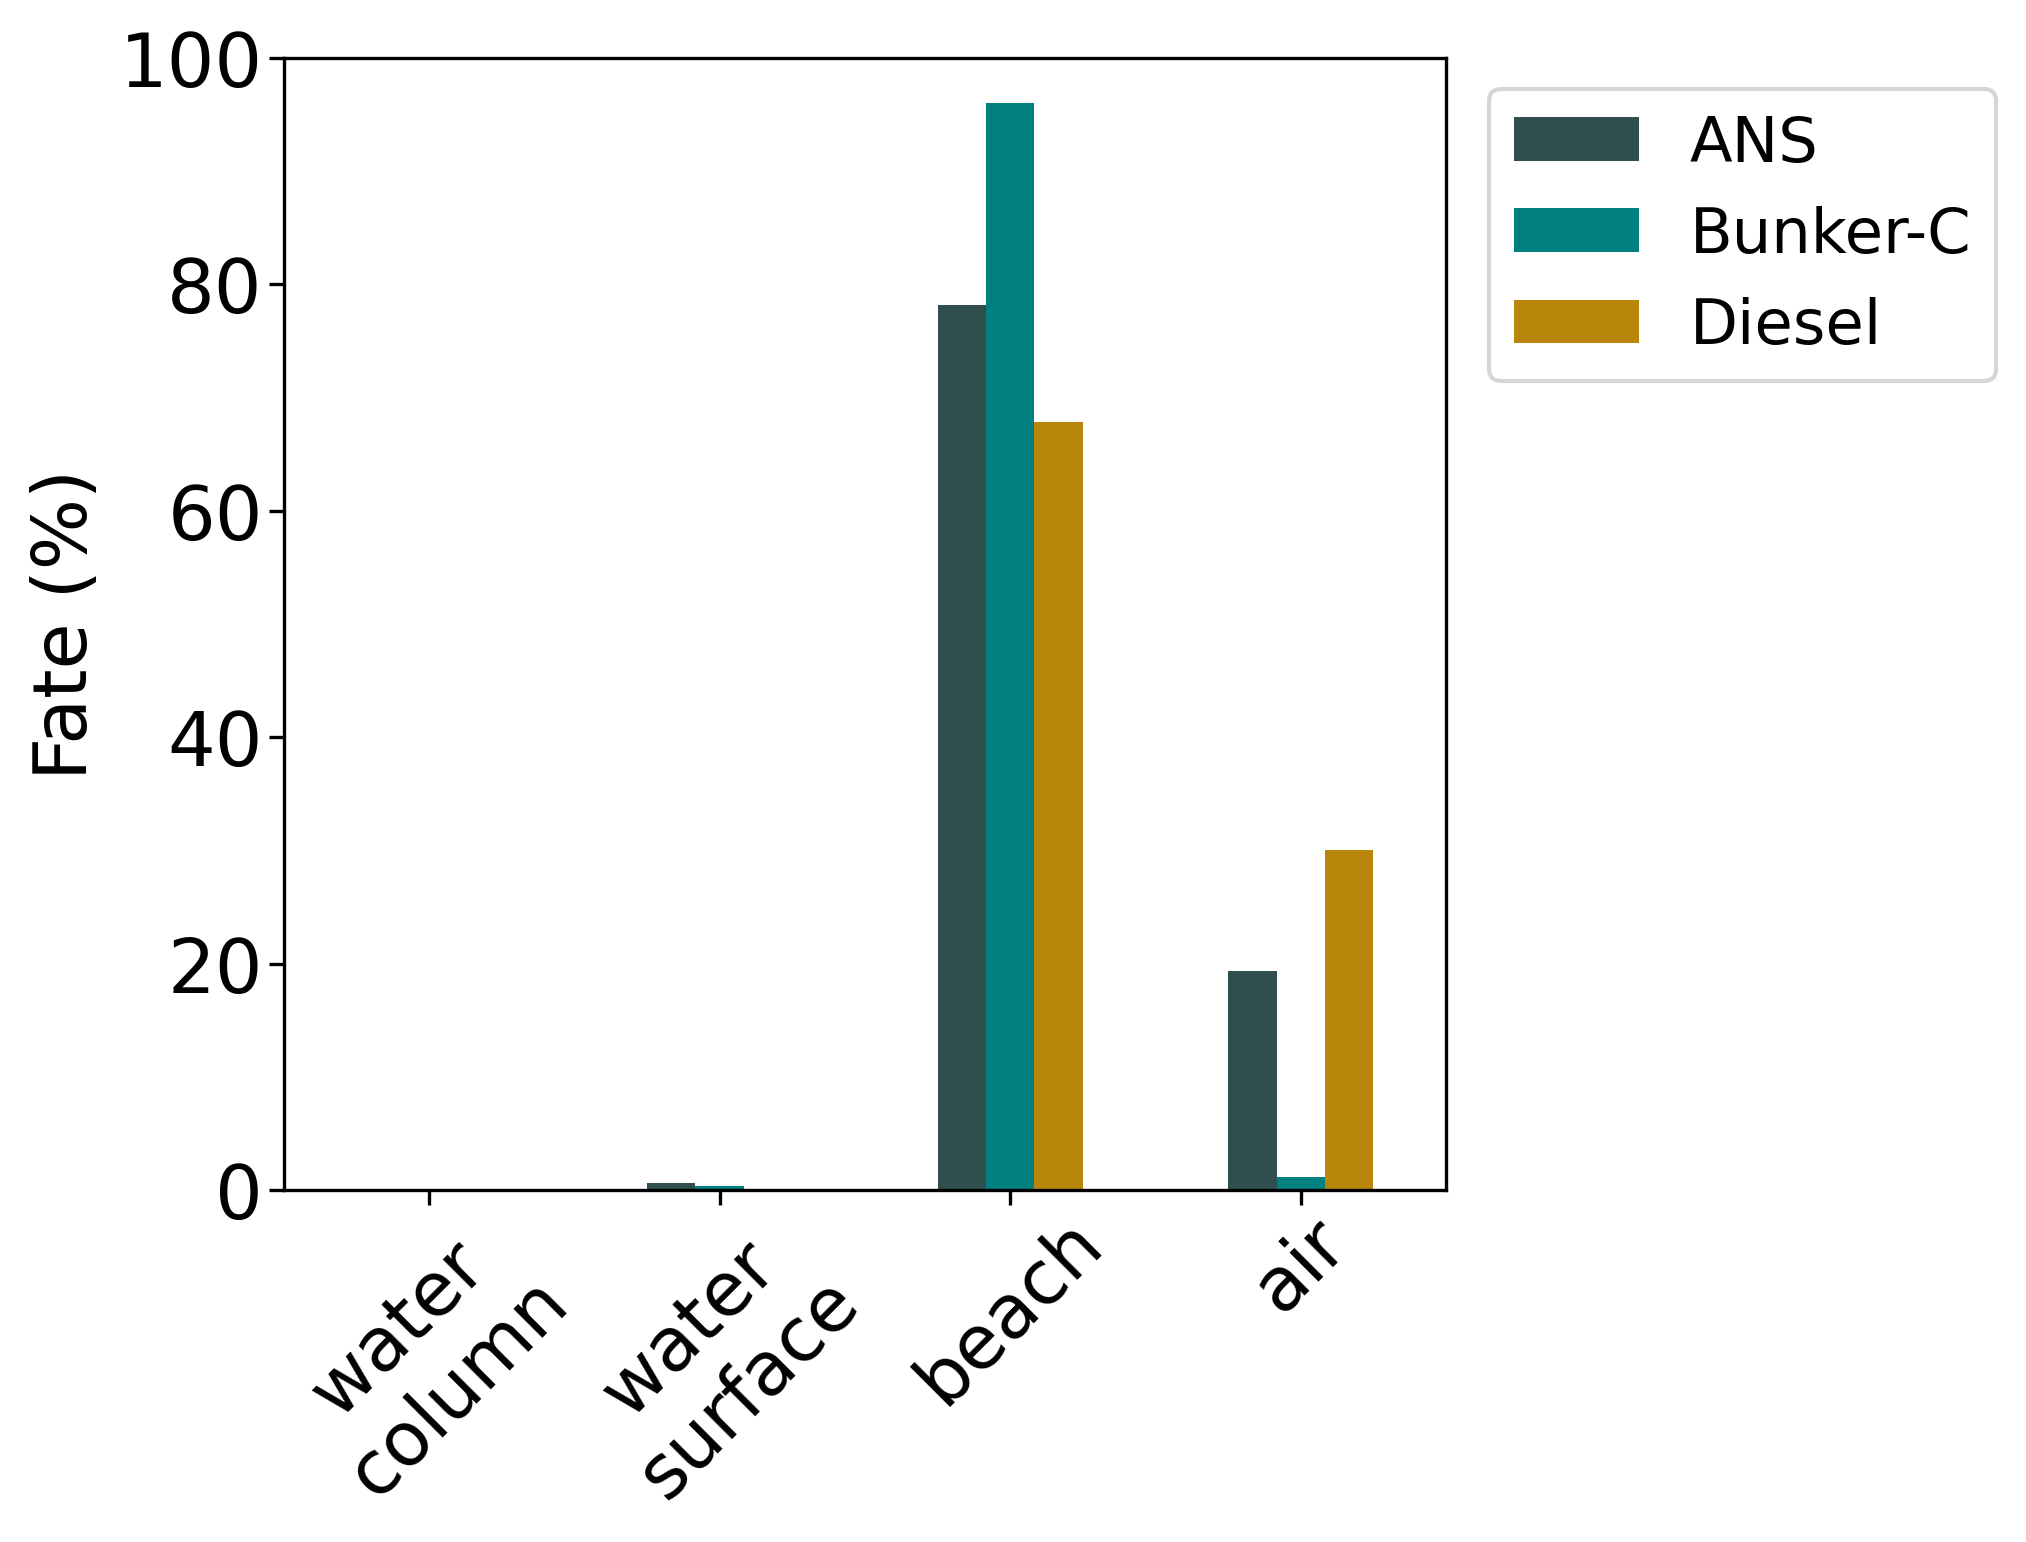

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1],
                       'wspace': 0.4,
                       'hspace': 0.2})
persist_df['median'].plot(ax=ax,
    kind="bar",
    color=[MIDOSScolors["ANS"],MIDOSScolors["Bunker-C"],MIDOSScolors["Diesel"]],
    legend=False,          
    #yerr=yerr_reorg, #np.append(error_max, error_min, axis=0), 
    error_kw=dict(lw=3, capsize=4, capthick=3),
    ecolor='lightsteelblue'
)
ax.set_ylabel("Fate (%)")
ax.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
ax.set_ylim(0,100)
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xticklabels(
    ["water\ncolumn", "water\nsurface", "beach", "air"],
    rotation=45
)

plt.savefig(graphics_dir/'Fate_ByOilLocation_1panel_MedianErr.png')

